In [153]:
import os
import cv2
import pickle

import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [69]:
def collect_images(class_names):
    
    '''
    This function takes in a list of 'class_names' and captures images using a webcam until the 'image_count' number is reached. 
    It will create folders if not already created for the 'class_names' and will populate those folders with the collected images.
    You can run this function by calling 'collect_images' with a list of your 'class_names' as a parameter.
    
    Example Usage:
        class_names = ['A', 'B', 'C', '1', '2', '3']
        collect_images(class_names)

    A window will open displaying the video from your webcam with instructions to press 'Q' to start image collection.
    In the notebook under this cell, text will display for which class the images will be collected for.
    
    Images are saved to a 'landmark_data' folder with subfolders titled with the provided 'class_names'.
    '''
    
    image_count=500 
    directory='../data/landmark_data/'
    
    if not os.path.exists(directory):
        os.makedirs(directory)

    cap = cv2.VideoCapture(0)

    for i in class_names:
        class_dir = os.path.join(directory, str(i))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        right_hand = 'Right Hand'
        print(f'Collecting {right_hand} Data for class {i}')

        while True:
            ret, frame = cap.read()
            text = f'Press Q to Start - {right_hand} {i}'
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)[0]
            text_x = (frame.shape[1] - text_size[0]) // 2 # Center-align text
            cv2.putText(frame, text, (text_x, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.imshow('frame', frame)
            if cv2.waitKey(25) == ord('q'):
                break

        counter_right = 0
        while counter_right < image_count:
            ret, frame = cap.read()
            cv2.imshow('frame', frame)
            cv2.waitKey(25)
            cv2.imwrite(os.path.join(class_dir, '{}.jpg'.format(counter_right)), frame)
            counter_right += 1    
        left_hand = 'Left Hand'
        print(f'Collecting {left_hand} Data for class {i}') 
            
        while True:
            ret, frame = cap.read()
            text = f'Press Q to Start - {left_hand} {i}'
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)[0]
            text_x = (frame.shape[1] - text_size[0]) // 2 # Center-align text
            cv2.putText(frame, text, (text_x, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.imshow('frame', frame)
            if cv2.waitKey(25) == ord('q'):
                break

        counter_left = 0
        while counter_left < image_count:
            ret, frame = cap.read()
            cv2.imshow('frame', frame)
            cv2.waitKey(25)
            cv2.imwrite(os.path.join(class_dir, '{}.jpg'.format(counter_left + counter_right)), frame)
            counter_left += 1

    cap.release()
    cv2.destroyAllWindows()

In [70]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'I Love You', 'Hello']
collect_images(class_names)

In [197]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3, max_num_hands=1)

directory = '../data/landmark_data/'

data, labels = [], []

for dir_ in os.listdir(directory):
    for img_path in os.listdir(os.path.join(directory, dir_)):
        data_aux, x_, y_ = [], [], []

        img = cv2.imread(os.path.join(directory, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)
        hand_landmarks = results.multi_hand_landmarks[0] if results.multi_hand_landmarks else None

        if hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x, y = hand_landmarks.landmark[i].x, hand_landmarks.landmark[i].y
                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x, y = hand_landmarks.landmark[i].x, hand_landmarks.landmark[i].y
                data_aux.extend([x - min(x_), y - min(y_)])

            data.append(data_aux)
            labels.append(dir_)

max_length = max(map(len, data))
data_padded = [sublist + [0] * (max_length - len(sublist)) for sublist in data]


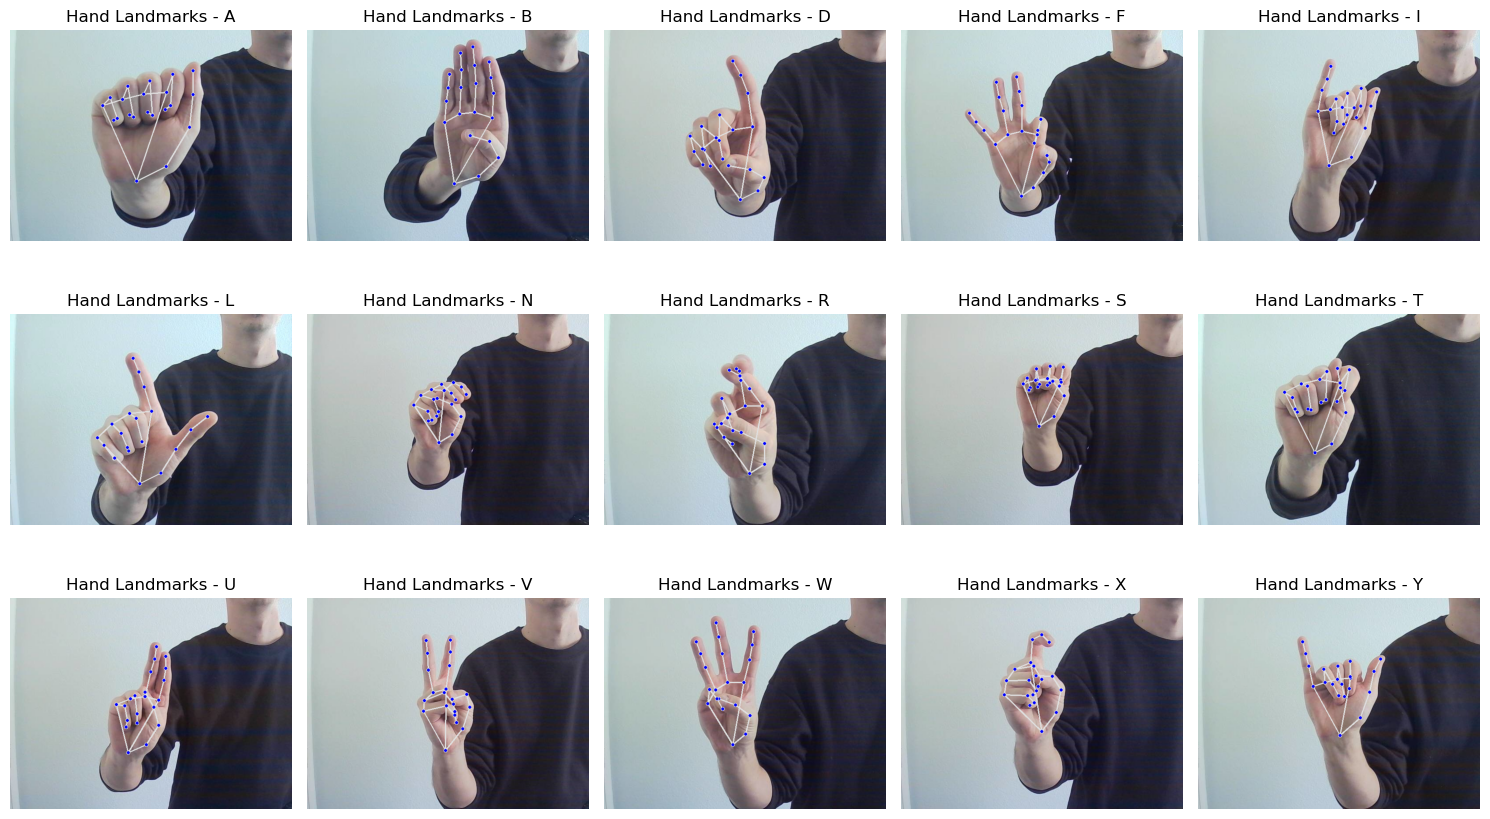

In [222]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

directory = '../data/landmark_data/'
folders_to_visualize = ['A', 'B', 'D', 'F', 'I', 'L', 'N', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i, folder in enumerate(folders_to_visualize):
    folder_path = os.path.join(directory, folder)
    img_paths = [os.path.join(folder_path, img_file) for img_file in os.listdir(folder_path) if img_file.endswith('.jpg')]

    img_path = img_paths[350]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = hands.process(img_rgb)
    landmarks = results.multi_hand_landmarks[0] if results.multi_hand_landmarks else None

    mp.solutions.drawing_utils.draw_landmarks(img_rgb, landmarks, mp_hands.HAND_CONNECTIONS) if landmarks else None

    ax = axs[i // 5, i % 5]
    ax.imshow(img_rgb)
    ax.set_title(f"Hand Landmarks - {folder}")
    ax.axis('off')

fig.tight_layout()
plt.savefig('../images/landmark_images.png', bbox_inches = 'tight')


In [201]:
with open('../data/landmark_data.pkl', 'wb') as file:
    pickle.dump({'data': data_padded, 'labels': labels}, file)

In [202]:
data_dict = pickle.load(open('../data/landmark_data.pkl', 'rb'))

data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

In [212]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True, stratify=labels)

In [213]:
model = RandomForestClassifier()

model.fit(x_train, y_train)

RandomForestClassifier()

In [214]:
y_pred = model.predict(x_test)

score = accuracy_score(y_pred, y_test)

print(f'{score * 100:.4f}% of samples were classified correctly !')

99.9036% of samples were classified correctly !


In [215]:
file = open('../data/landmark_model.pkl', 'wb')
pickle.dump({'model': model}, file)
file.close()

In [216]:
model_dict = pickle.load(open('../data/landmark_model.pkl', 'rb'))

model = model_dict['model']

In [217]:
cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

folder_path = "../data/landmark_data/"
labels_list = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

while True:

    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()

    H, W, _ = frame.shape

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))
                data_aux.append(y - min(y_))

        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10

        x2 = int(max(x_) * W) - 10
        y2 = int(max(y_) * H) - 10

        if (len(data_aux) != 84):
            prediction = model.predict([np.asarray(data_aux)])
            predicted_character = prediction[0]
            # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4) # Frame around hand
            cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, # Prediction text
                        cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()